## **Using a Convolutional Neural Network to Identify Simulated Nanoparticle Rotations | Regression Model**

In this notebook, a convolutional neural network will be constructed and trained on images of simulated nanoparticles. The aim of the neural network is to correctly identify the rotations of these nanoparticles. TensorFlow2 and Keras will be used to create a regression model.

All of my work can be found at https://github.com/javidahmed64592/Y4-Nanoparticles-Project.

# Importing the relevant libraries.

In [ ]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import csv
import PIL
from scipy.spatial.transform import Rotation as R

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping

# Creating the dataset.

The images are loaded in from Google Drive.

In [ ]:
from google.colab import drive
drive_path = "/content/drive"
drive.mount(drive_path)

cwd = os.path.join(drive_path, "MyDrive", "Nanoparticles")
folder_name = "Tetrahedrons Centred W 15-15 RX 0-45 RY 0-45"
direc = os.path.join(cwd, folder_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The following function loads in images from a specified folder path. The folder contains subfolders for each nanoparticle orientation. The images are loaded in using PIL as NumPy arrays and returns them along with the file name and their orientations.

In [ ]:
def load_imgs_from_path(folder_path):
  """
  Loads in images from specified folder path.

  Inputs:
    folder_path: String, folder containing all subfolders of images
  
  Outputs:
    imgs: NumPy array, array of image arrays from files
    labels: NumPy array, array of labels corresponding to imgs
  """
  print("\nLoading images from '%s'..." % folder_path.split("/")[-1])
  imgs = []
  labels = []

  counter = 0
  
  for rotation in os.listdir(folder_path):
    rotation_path = os.path.join(folder_path, rotation)
    label = np.asarray(json.loads(rotation.split("_")[1]))
    for image_name in os.listdir(rotation_path):
      labels.append(np.asarray(label))
      img = PIL.Image.open(os.path.join(rotation_path, image_name)).convert('L')

      img_array = np.asarray(img)
      imgs.append(img_array)

      counter += 1
      print("\r%s images loaded." % (counter), end='', flush=True)

      img.close()

  imgs = np.asarray(imgs)
  imgs = imgs.reshape(*imgs.shape, 1)

  print("\rFound %s images from the '%s' dataset." % (counter, folder_path.split("/")[-1]), end='', flush=True)

  return imgs, np.asarray(labels)

The required folder paths are specified, and the training and validation datasets are assigned. 80% of the images in total are used for training, and 20% for validation.

In [ ]:
dr_train = 2.5
training_path = os.path.join(direc, "Train DR%s" % dr_train)
validation_path = os.path.join(direc, "Valid DR%s" % dr_train)

In [ ]:
begin_time = datetime.datetime.now()

train_imgs, train_labels = load_imgs_from_path(training_path)
valid_imgs, valid_labels = load_imgs_from_path(validation_path)

dt = datetime.datetime.now() - begin_time
dt_m = int(dt.total_seconds() // 60)
dt_s = int(dt.total_seconds() - (dt_m*60))
print("\n\nDone! The time it took is %sm %ss." % (dt_m, dt_s))


Loading images from 'Train DR2.5'...
Found 4332 images from the 'Train DR2.5' dataset.
Loading images from 'Valid DR2.5'...
Found 1083 images from the 'Valid DR2.5' dataset.

Done! The time it took is 23m 39s.


The following neural network layers are used to resize the images and map their pixel values to a float between 0 and 1. The training and validation images will have random augmentations applied to them.

In [ ]:
train_augmentation = keras.Sequential(
  [
    layers.Resizing(*img_size),
    layers.Rescaling(1./255.),
    layers.RandomContrast(0.15)
  ]
)

The following function creates a dataset from the image arrays and their corresponding labels along with one of the above augmentations and a batch size. The dataset is shuffled and the images are prefetched to use with the model.

In [ ]:
def create_dataset(imgs, labels, aug, batch_size):
  """
  Creates a TensorFlow dataset.

  Inputs:
    imgs: NumPy array, array of images
    labels: NumPy array, labels corresponding to each image
    aug: Keras Sequential, layers to use for data augmentation
    batch_size: Integer, batch size to use for dataset

  Outputs:
    dataset: TensorFlow dataset, image dataset from files
  """
  dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))
  
  dataset = dataset.shuffle(batch_size * 100)

  dataset = (
    dataset
    .batch(batch_size)
    .map(lambda x, y: (aug(x), y),
      num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
  )
  return dataset

In [ ]:
batch_size = 4
img_size = [64, 64] # Image dimensions

train_dataset = create_dataset(train_imgs, train_labels, train_augmentation, batch_size)
valid_dataset = create_dataset(valid_imgs, valid_labels, train_augmentation, batch_size)

# Creating the model.

The following function shows the layers of the convolutional neural network.

In [ ]:
def get_model(n_outputs):
  """
  Creates a TensorFlow neural network.

  Inputs:
    n_outputs: Integer, number of output nodes of the model

  Outputs:
    model: TensorFlow sequential, model to train
  """
  model = Sequential([
    layers.InputLayer(input_shape=(*img_size, 1)),
    layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(*img_size, 1), name='Convolution_16_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_1'),
    layers.Conv2D(32, 3, padding='same', activation='relu', name='Convolution_32_3x3'),
    layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_2'),
    # layers.Conv2D(64, 3, activation='relu', name='Convolution_64_3x3_3'),
    # layers.MaxPooling2D(pool_size=2, strides=2, name='Max_Pooling_2x2_Stride_2_3'),
    # layers.Dropout(0.1, name='Dropout_10'),
    layers.Flatten(name='Flatten'),
    # layers.Dense(img_size[0], activation='relu', name='Dense_%s_1' % img_size[0]),
    # layers.Dense(img_size[0] * 2, activation='relu', name='Dense_%s_2' % (img_size[0] * 2)),
    # layers.Dense(img_size[0] * 4, activation='relu', name='Dense_%s_3' % (img_size[0] * 4)),
    # layers.Dense(img_size[0] * 2, activation='relu', name='Dense_%s_4' % (img_size[0] * 2)),
    layers.Dense(img_size[0], activation='relu', name='Dense_%s_5' % img_size[0]),
    layers.Dense(n_outputs, activation='tanh', name='Dense_%s_O' % n_outputs)
  ])

  return model

The model is created and compiled using mean squared error for the loss.

In [ ]:
model = get_model(train_labels.shape[1])
model._name = "Nanoparticle_Regression"

opt = SGD(learning_rate=7e-04)
model.compile(optimizer=opt,
              loss='mse',
              metrics=['accuracy']
)

model.summary()

Model: "Nanoparticle_Regression"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Convolution_16_3x3 (Conv2D)  (None, 64, 64, 16)       160       
                                                                 
 Max_Pooling_2x2_Stride_2_1   (None, 32, 32, 16)       0         
 (MaxPooling2D)                                                  
                                                                 
 Convolution_32_3x3 (Conv2D)  (None, 32, 32, 32)       4640      
                                                                 
 Max_Pooling_2x2_Stride_2_2   (None, 16, 16, 32)       0         
 (MaxPooling2D)                                                  
                                                                 
 Flatten (Flatten)           (None, 8192)              0         
                                                                 
 Dense_64_5 (Dense)          (None, 64)    

# Training the model.

The model is trained for 100 epochs.

In [ ]:
epochs = 100

history = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=epochs
)

Epoch 1/100
1083/1083 [==============================] - 19s 17ms/step - loss: 0.0678 - accuracy: 0.6212 - val_loss: 0.0291 - val_accuracy: 0.4737
Epoch 2/100
1083/1083 [==============================] - 18s 17ms/step - loss: 0.0181 - accuracy: 0.6214 - val_loss: 0.0274 - val_accuracy: 0.4737
Epoch 3/100
1083/1083 [==============================] - 18s 17ms/step - loss: 0.0164 - accuracy: 0.6293 - val_loss: 0.0273 - val_accuracy: 0.4737
Epoch 4/100
1083/1083 [==============================] - 18s 17ms/step - loss: 0.0160 - accuracy: 0.6473 - val_loss: 0.0269 - val_accuracy: 0.4737
Epoch 5/100
1083/1083 [==============================] - 18s 17ms/step - loss: 0.0157 - accuracy: 0.6627 - val_loss: 0.0264 - val_accuracy: 0.4737
Epoch 6/100
1083/1083 [==============================] - 19s 17ms/step - loss: 0.0154 - accuracy: 0.6646 - val_loss: 0.0263 - val_accuracy: 0.4737
Epoch 7/100
1083/1083 [==============================] - 19s 17ms/step - loss: 0.0151 - accuracy: 0.6717 - val_loss: 0

Visualising the training results.

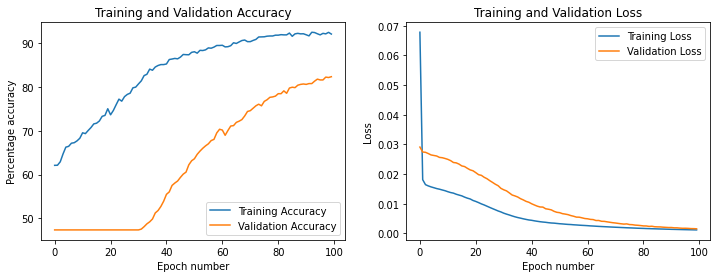

In [ ]:
acc = np.array(history.history['accuracy'])
val_acc = np.array(history.history['val_accuracy'])

loss = np.array(history.history['loss'])
val_loss = np.array(history.history['val_loss'])

epochs_range = range(epochs)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc * 100, label='Training Accuracy')
plt.plot(epochs_range, val_acc * 100, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel("Epoch number")
plt.ylabel("Percentage accuracy")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch number")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.show()

# Using the test dataset to assess the model's prediction accuracy.

The following class handles predictions for each group in the test dataset, each group being a subfolder in the test dataset folder. Each group corresponds to a different orientation of the nanoparticle in the image. The class loads in the images from the subfolder and creates a TensorFlow dataset.

The rotations are applied to the nanoparticles using 3x3 rotation matrices. The Gram–Schmidt process can then be used to represent this 3x3 matrix in 6D. The class can convert this 6D representation back into a matrix from which the Euler angles can be calculated.

The absolute difference between the predicted and true rotation for each image is then calculated, and this can be plotted as well as the predictions themselves.

In [ ]:
class prediction_handler:
  """
  This class is used to store data about predicted images from each rotation.
  The folder path is specified and the shape and its rotation are saved. Each
  image belonging to that shape and rotation is then used to test the model and
  the average absolute difference between the true and predicted rotations are
  is calculated.
  """
  def __init__(self, folder_path):
    """
    Initialise the class.

    Inputs:
      folder_path: String, subfolder in training folder with shape and rotation
    """
    self.folder_path = folder_path
    label = self.folder_path.split("/")[-1]
    self.actual_shape = label.split("_")[0]
    self.label6d = json.loads(label.split("_")[-1])
    self.actual_rotation = self.calculate_euler(self.label6d)
    self.img_paths = []
    self.total = 0
    self.predictions = []
    self.load_img_paths()
    self.run()

  def calculate_euler(self, label):
    """
    Calculates Euler angles from 6D representation of rotation.

    Inputs:
      label: List, 6 floats corresponding to numbers in rotation matrix
    
    Outputs:
      rotation_euler: NumPy array, 1x3 array of Euler angles rounded to 1dp
    """
    rotation = np.array(label).reshape((2, 3)).T
    
    v1 = rotation[:, 0]
    v2 = rotation[:, 1]
    e1 = v1 / np.linalg.norm(v1)
    u2 = v2 - (np.dot(np.dot(e1, v2), e1))
    e2 = u2 / np.linalg.norm(u2)
    e3 = np.cross(e1, e2)

    rotation_so3 = np.vstack((e1, e2, e3)).T

    rotation_euler = R.from_matrix(rotation_so3).as_euler("xyz", degrees=True)

    return np.round(rotation_euler, 1)

  def load_img_paths(self):
    """
    Appends the path to each image to a list and creates a TensorFlow dataset.
    """
    imgs = []
    labels = []

    for img_path in os.listdir(self.folder_path):
      if img_path not in self.img_paths:
        full_path = os.path.join(self.folder_path, img_path)
        self.img_paths.append(full_path)
        img = PIL.Image.open(full_path).convert('L')
        img = img.resize(img_size)
        img_array = np.asarray(img)
        img_array = np.reshape(img_array, [-1, img_size[0], img_size[1], 1])
        imgs.append(img_array)
        labels.append(self.label6d)

    self.dataset = tf.data.Dataset.from_tensor_slices((imgs, labels))

  def run(self):
    """
    Predicts each image belonging to this class and calculates the average
    absolute difference between true and predicted rotations.
    """
    predictions = model.predict(self.dataset)

    self.predictions = []

    for prediction in predictions:
      self.predictions.append(self.calculate_euler(prediction))

    self.predictions = np.abs(np.asarray(self.predictions))
    self.avg_pred = np.mean(self.predictions, axis=0)
    
    self.dif = np.abs(self.predictions - self.actual_rotation)
    self.avg_dif = np.mean(self.dif, axis=0)
    self.total = len(self.predictions)

  def plot_predictions(self):
    """
    Plots the neural network's predictions.
    """
    plt.figure(figsize=(12, 7))
    x = np.arange(self.total)

    plt.scatter(x, self.predictions[:,0], c='b')#, label='Predicted angle rx')
    plt.hlines(self.avg_pred[0], x[0], x[-1], 'b', label='Average predicted angle rx = %s°' % np.round(self.avg_pred[0], 2))
    plt.hlines(self.actual_rotation[0], x[0], x[-1], 'b', linestyles='dashed', label='Expected angle rx = %s°' % self.actual_rotation[0])

    plt.scatter(x, self.predictions[:,1], c='r')#, label='Predicted angle ry')
    plt.hlines(self.avg_pred[1], x[0], x[-1], 'r', label='Average predicted angle ry = %s°' % np.round(self.avg_pred[1], 2))
    plt.hlines(self.actual_rotation[1], x[0], x[-1], 'r', linestyles='dashed', label='Expected angle ry = %s°' % self.actual_rotation[1])

    plt.scatter(x, self.predictions[:,2], c='g')#, label='Predicted angle rz')
    plt.hlines(self.avg_pred[2], x[0], x[-1], 'g', label='Average predicted angle rz = %s°' % np.round(self.avg_pred[2], 2))
    plt.hlines(self.actual_rotation[2], x[0], x[-1], 'g', linestyles='dashed', label='Expected angle rz = %s°' % self.actual_rotation[2])

    plt.ylabel("Predicted angle (°)")
    plt.xlim([x[0], x[-1]])
    plt.ylim([-45, 45])
    plt.legend(loc='best')
    plt.title("Model Predictions | Euler Angles RX%s RY%s RZ%s" % (self.actual_rotation[0], self.actual_rotation[1], self.actual_rotation[2]))
    plt.show()

  def plot_difs(self):
    """
    Plots the difference between the neural network's predictions and the true rotation.
    """
    plt.figure(figsize=(12, 7))
    x = np.arange(self.total)
    plt.scatter(x, self.dif[:,0], c='b', label='Absolute difference in rx')
    plt.hlines(self.avg_dif[0], x[0], x[-1], 'b', label='Average difference in rx = %s°' % self.avg_dif[0])
    plt.scatter(x, self.dif[:,1], c='r', label='Absolute difference in ry')
    plt.hlines(self.avg_dif[1], x[0], x[-1], 'r', label='Average difference in ry = %s°' % self.avg_dif[1])
    plt.scatter(x, self.dif[:,2], c='g', label='Absolute difference in rz')
    plt.hlines(self.avg_dif[2], x[0], x[-1], 'g', label='Average difference in rz = %s°' % self.avg_dif[2])
    plt.ylabel("Difference in angle (°)")
    plt.xlim([x[0], x[-1]])
    plt.ylim([0, 45])
    plt.legend(loc='best')
    plt.title("Model Predictions | Euler Angles RX%s RY%s RZ%s" % (self.actual_rotation[0], self.actual_rotation[1], self.actual_rotation[2]))
    plt.show()

# Loading in the images.

The images in each group are used to test the model. The predictions are then sorted to be displayed in a graph.

In [ ]:
dr_test = 2.5
testing_path = os.path.join(direc, "Test DR%s" % dr_test)

true_rotations = [] # True rotations of each simulated nanoparticle
prediction_groups = []
avg_pred_rotations = []
avg_dif_rotations = [] # Average absolute difference between true and predicted rotations

counter = 1
rotations = os.listdir(testing_path)
total_rotations = len(rotations)

for rotation in rotations:
  print("\rPredicting rotation %s of %s." % (counter, total_rotations), end='', flush=True)
  rotation_path = os.path.join(testing_path, rotation)
  rotation_object = prediction_handler(rotation_path)
  prediction_groups.append(rotation_object)
  true_rotations.append(rotation_object.actual_rotation)
  avg_pred_rotations.append(rotation_object.avg_pred)
  avg_dif_rotations.append(rotation_object.avg_dif)
  counter += 1

print("\rAll rotations predicted.", end='', flush=True)

true_rotations = np.asarray(true_rotations)
prediction_groups = np.asarray(prediction_groups)
avg_pred_rotations = np.asarray(avg_pred_rotations)
avg_dif_rotations = np.asarray(avg_dif_rotations)

All rotations predicted.

Sorting the results in order of increasing angle.

In [ ]:
rx_min = np.min(true_rotations[:,0])
rx_max = np.max(true_rotations[:,0])
ry_min = np.min(true_rotations[:,1])
ry_max = np.max(true_rotations[:,1])

def sort_and_reshape_array(true_rots, avg_preds, avg_difs, indices):
  """
  Sorts the true rotations and average differences in order of increasing angle.
  The indices determine which axis to use for the order.

  Inputs:
    true_rots: NumPy array, Nx3 array of Euler angles
    avg_preds: NumPy array, Nx3 array of predicted rotations
    avg_difs: NumPy array, Nx3 array of differences between true and predicted rotations
    indices: List, [0,1] to sort using x-axis, [1, 0] for y-axis

  Outputs:
    ordered_rots: NumPy array, Nx3 sorted array of Euler angles
    ordered_avg_pred_rotations: NumPy array, Nx3 sorted array of predicted angles
    ordered_avg_dif_rotations: NumPy array, Nx3 sorted array of differences between true and predicted rotations
  """
  order = np.lexsort((true_rots[:,indices[0]], true_rots[:,indices[1]]))
  ordered_rots = true_rots[order]
  ordered_avg_pred_rotations = avg_preds[order]
  ordered_avg_dif_rotations = avg_difs[order]

  new_shape_dim = int(np.sqrt(ordered_rots.shape[0]))
  new_shape = (new_shape_dim, new_shape_dim, ordered_rots.shape[1])

  ordered_rots = ordered_rots.reshape((new_shape))
  ordered_avg_pred_rotations = ordered_avg_pred_rotations.reshape((new_shape))
  ordered_avg_dif_rotations = ordered_avg_dif_rotations.reshape((new_shape))

  return ordered_rots, ordered_avg_pred_rotations, ordered_avg_dif_rotations

In [ ]:
ordered_rots_x, ordered_avg_pred_x, ordered_avg_dif_x = sort_and_reshape_array(true_rotations, avg_pred_rotations, avg_dif_rotations, [0, 1])
ordered_rots_y, ordered_avg_pred_y, ordered_avg_dif_y = sort_and_reshape_array(true_rotations, avg_pred_rotations, avg_dif_rotations, [1, 0])

# Visualising the model's accuracy.

The average predicted angles and absolute differences between the true and predicted angles are plotted versus true rotation around the x-axis and y-axis. The different lines in both graphs represent different angles of rotation about the other axis to the one shown in each graph, with black to red representing increasing angle.

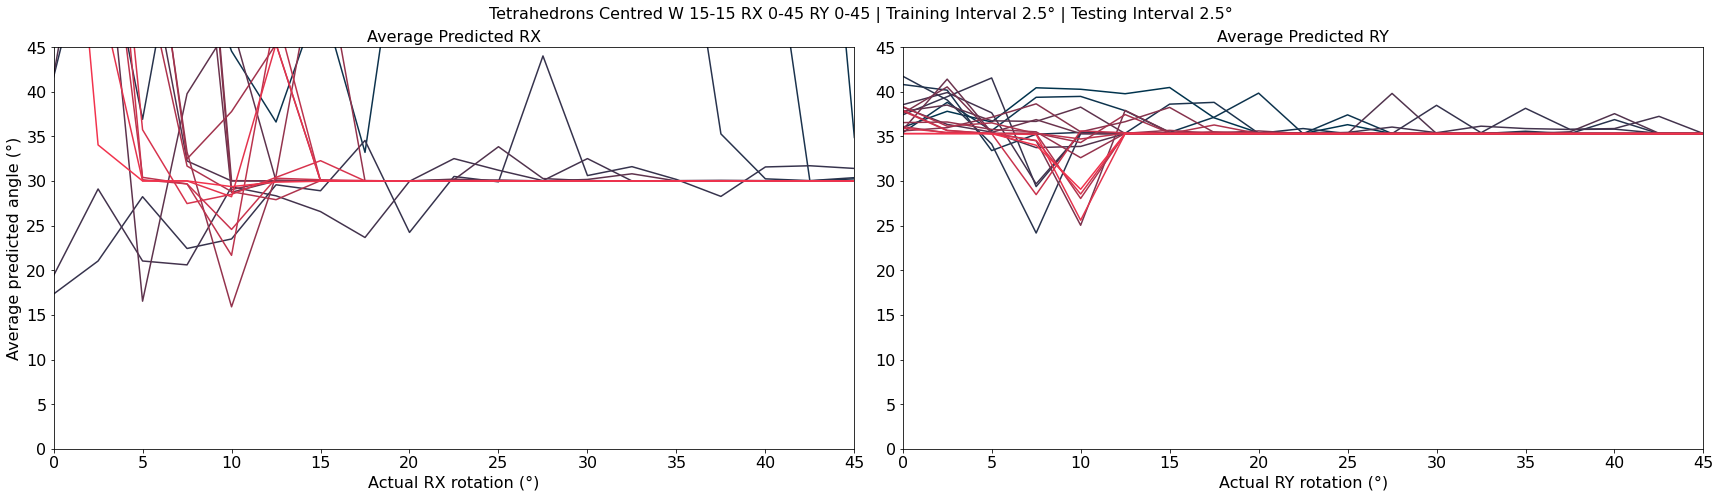

In [ ]:
fig_pred = plt.figure(figsize=(24, 7))

plt.subplot(121)

for index in range(ordered_rots_x.shape[0]):
  actual_rotation = ordered_rots_x[index][:,0]
  rotation_pred = ordered_avg_pred_x[index][:,0]
  plt.plot(actual_rotation, rotation_pred, c=(index / ordered_rots_x.shape[0], 0.2, 0.3), label='RY%s RZ%s' % (ordered_rots_x[index][0][1], ordered_rots_x[index][0][2]))

plt.xlabel("Actual RX rotation (°)", fontsize=16)
plt.ylabel("Average predicted angle (°)", fontsize=16)
plt.xlim([rx_min, rx_max])
plt.ylim([0, 45])
plt.title("Average Predicted RX", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='best', fontsize=14)

plt.subplot(122)

for index in range(ordered_rots_y.shape[0]):
  actual_rotation = ordered_rots_y[index][:,1]
  rotation_pred = ordered_avg_pred_y[index][:,1]
  plt.plot(actual_rotation, rotation_pred, c=(index / ordered_rots_y.shape[0], 0.2, 0.3), label="RX%s RZ%s" % (ordered_rots_y[index][0][0], ordered_rots_y[index][0][2]))

plt.xlabel("Actual RY rotation (°)", fontsize=16)
plt.xlim([rx_min, rx_max])
plt.ylim([0, 45])
plt.title("Average Predicted RY", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='best', fontsize=14)

plt.suptitle("%s | Training Interval %s° | Testing Interval %s°" % (folder_name, dr_train, dr_test), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()

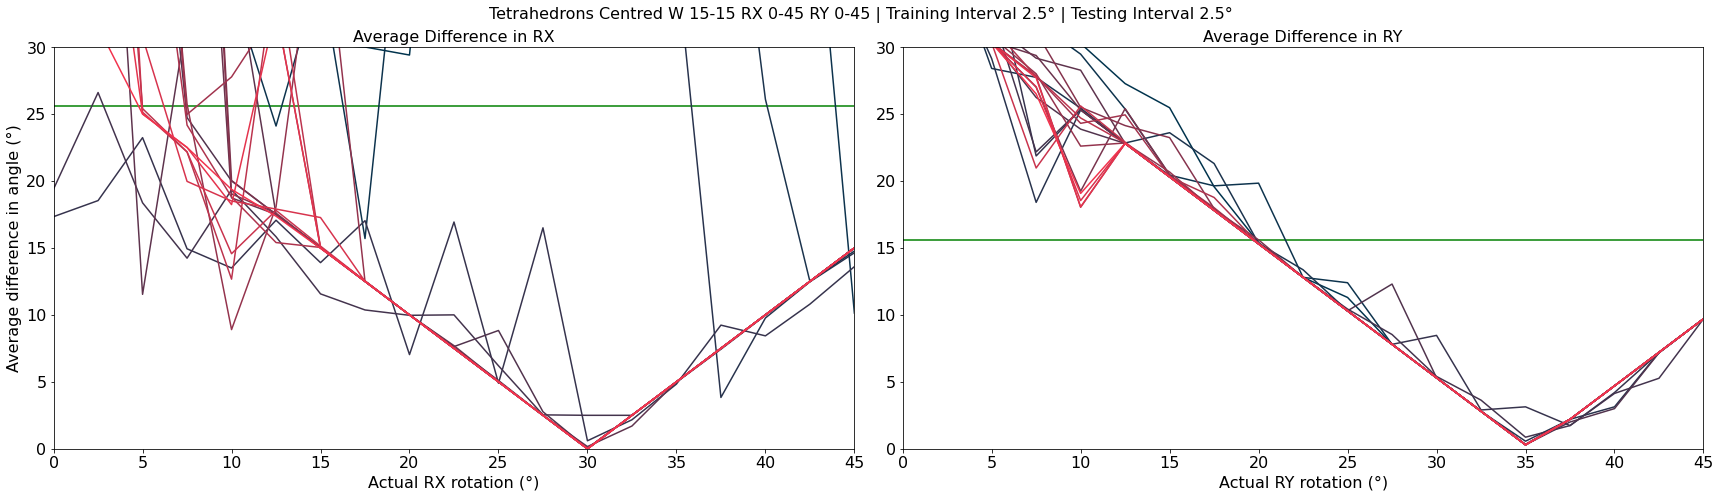

In [ ]:
drx = []
dry = []

fig_dif = plt.figure(figsize=(24, 7))

plt.subplot(121)

for index in range(ordered_rots_x.shape[0]):
  actual_rotation = ordered_rots_x[index][:,0]
  rotation_dif = ordered_avg_dif_x[index][:,0]
  plt.plot(actual_rotation, rotation_dif, c=(index / ordered_rots_x.shape[0], 0.2, 0.3), label="RY%s RZ%s" % (ordered_rots_x[index][0][1], ordered_rots_x[index][0][2]))
  drx.append(rotation_dif)

drx = np.asarray(drx)
mean_x = np.mean(drx)
plt.hlines(mean_x, rx_min, rx_max, color='g', label="Mean difference in RX = %s°" % round(mean_x, 2))
plt.xlabel("Actual RX rotation (°)", fontsize=16)
plt.ylabel("Average difference in angle (°)", fontsize=16)
plt.xlim([rx_min, rx_max])
plt.ylim([0, 30])
plt.title("Average Difference in RX", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='best', fontsize=14)

plt.subplot(122)

for index in range(ordered_rots_y.shape[0]):
  actual_rotation = ordered_rots_y[index][:,1]
  rotation_dif = ordered_avg_dif_y[index][:,1]
  plt.plot(actual_rotation, rotation_dif, c=(index / ordered_rots_y.shape[0], 0.2, 0.3), label="RX%s RZ%s" % (ordered_rots_y[index][0][0], ordered_rots_y[index][0][2]))
  dry.append(rotation_dif)

dry = np.asarray(dry)
mean_y = np.mean(dry)
plt.hlines(mean_y, ry_min, ry_max, color='g', label="Mean difference in RY = %s°" % round(mean_y, 2))
plt.xlabel("Actual RY rotation (°)", fontsize=16)
plt.xlim([rx_min, rx_max])
plt.ylim([0, 30])
plt.title("Average Difference in RY", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.legend(loc='best', fontsize=14)

plt.suptitle("%s | Training Interval %s° | Testing Interval %s°" % (folder_name, dr_train, dr_test), fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.90)

plt.show()

# Saving the results.

The above graphs are saved into a "Results" subfolder.

In [ ]:
results_direc = os.path.join(direc, "Results", "Regression Results")

if not os.path.exists(results_direc):
  os.makedirs(results_direc)

pred_name = "Regression Pred DR_train%s DR_test%s.png" % (dr_train, dr_test)
dif_name = "Regression Dif DR_train%s DR_test%s.png" % (dr_train, dr_test)
fig_pred.savefig(os.path.join(results_direc, pred_name))
fig_dif.savefig(os.path.join(results_direc, dif_name))

The data is saved to a .csv file to be analysed in the notebook *AnalyseModelPredictions.ipynb*. If the file does not exist already then one is created and headers are added in the first row. The data to be added is the angle between each orientation in the training and test dataset as well as the average absolute difference between the true and predicted rotations.

In [ ]:
results_name = "Regression Results.csv"
results_csv = os.path.join(results_direc, results_name)

if not os.path.exists(results_csv):
  with open(results_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["DR TRAIN", "DR TEST", "RX AVG DIF", "RY AVG DIF"])

The data is added as a new row.

In [ ]:
with open(results_csv, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow([dr_train, dr_test, mean_x, mean_y])

Printing the .csv file.

In [ ]:
with open(results_csv, 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        print(row)

['DR TRAIN', 'DR TEST', 'RX AVG DIF', 'RY AVG DIF']
['2.5', '2.5', '11.409972299168976', '11.74487534626039']
['2.5', '2.5', '25.63028624192059', '15.576731301939061']
